In [6]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0
  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0
  gnutls             conda-forge/linux-64::gnutls-3.6.13-h85f3911_1
  lame               conda-forge/linux-64::lame-3.100-h7f98852_1001
  libiconv           conda-forge/linux-64::libiconv-1.16-h516909a_0
  nettle             conda-forge/linux-64::nettle-3.6-he412f7d_0
  openh264           conda-forge/linux-64::openh264-2.1.1-h780b84a_0
  torchaudio         pytorch/linux-64::torchaudio-0.11.0-py37_cu113
  torchvision        pytorch/linux-64::torchvision-0.12.0-py37_cu113

The following packages will be UPDATED:

  certifi                          2021.10.8-py37h89c1867_1 -->

In [7]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.50, 0.50, 0.50), (0.50, 0.50, 0.50))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


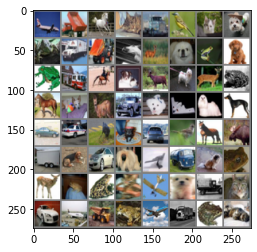

plane truck horse   cat truck  bird   cat   dog  frog truck truck horse  deer   dog  frog   dog  frog truck horse   dog  deer   dog  deer  frog horse   dog  deer   car   dog plane   dog   dog   car   car  bird   dog   car  bird horse  deer truck   dog   car   dog plane truck   dog  frog  deer  frog  frog   cat plane   dog truck   cat   car plane truck  frog plane truck  frog   cat


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3_2(self.conv3_1(x))))
        x = self.dropout3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 100
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))

    valid_loss = 0.0
    valid_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for inputs, labels in testloader:
        inputs,labels=inputs.to(device),labels.to(device)
        # Forward Pass
        outputs = net(inputs)
        # Find the Loss
        loss = criterion(outputs,labels)
        # Calculate Loss
        valid_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        valid_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Loss:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/100 	 Training Loss: 2.1733 	 Validation Loss: 1.9332 	 Training Accuracy: 0.1685 	 Validation Loss:0.2981
Epoch 2/100 	 Training Loss: 1.5952 	 Validation Loss: 1.3975 	 Training Accuracy: 0.4069 	 Validation Loss:0.4879
Epoch 3/100 	 Training Loss: 1.2788 	 Validation Loss: 1.1755 	 Training Accuracy: 0.5333 	 Validation Loss:0.5789
Epoch 4/100 	 Training Loss: 1.0874 	 Validation Loss: 1.073 	 Training Accuracy: 0.6128 	 Validation Loss:0.622
Epoch 5/100 	 Training Loss: 0.9406 	 Validation Loss: 0.9802 	 Training Accuracy: 0.6683 	 Validation Loss:0.6577
Epoch 6/100 	 Training Loss: 0.8315 	 Validation Loss: 0.8838 	 Training Accuracy: 0.7069 	 Validation Loss:0.6954
Epoch 7/100 	 Training Loss: 0.7416 	 Validation Loss: 0.8602 	 Training Accuracy: 0.7412 	 Validation Loss:0.6985
Epoch 8/100 	 Training Loss: 0.6711 	 Validation Loss: 0.8158 	 Training Accuracy: 0.7655 	 Validation Loss:0.7248
Epoch 9/100 	 Training Loss: 0.5911 	 Validation Loss: 0.8304 	 Training Accuracy:

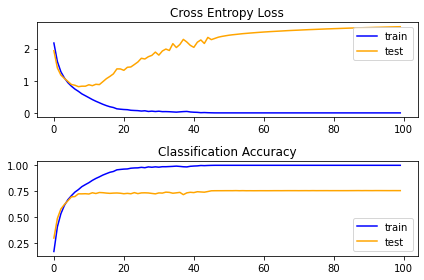

In [11]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
overall_acc = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 78.8 %
Accuracy for class car   is: 85.2 %
Accuracy for class bird  is: 66.1 %
Accuracy for class cat   is: 57.0 %
Accuracy for class deer  is: 71.9 %
Accuracy for class dog   is: 66.3 %
Accuracy for class frog  is: 81.4 %
Accuracy for class horse is: 80.2 %
Accuracy for class ship  is: 86.2 %
Accuracy for class truck is: 82.7 %
